## Kernel Analysis

In [1]:
## Import packages
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from skimage import filters
from sklearn.preprocessing import normalize 

In [2]:
## Import model
name = "modelName"
model = tf.keras.models.load_model(f'../models/{name}.keras')
# model.summary()

In [3]:
# Load Kernels
kernels, biases = model.layers[0].get_weights()

Text(-6.7, -1, 'All 3 kernels from the first layer network')

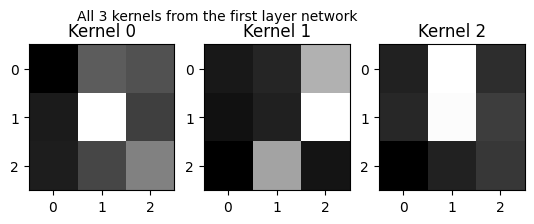

In [4]:
# Output all kernels of first layer of network
for i in range(0,3):
    plt.subplot(1,3,i+1)
    plt.title(f"Kernel {i}")
    plt.imshow(kernels[i].squeeze(), cmap="binary")

plt.text(-6.7, -1, "All 3 kernels from the first layer network")

In [5]:
## Define a single pixel 3 by 3 image to extract the actual filters upon application
I = np.zeros((3,3))
I[1,1] = 1

## Get filters from python library
my_filter_dict = {}
plot = False
for f in dir(filters):
    if f != "try_all_threshold":# This one causes some to be drawn and just calls the other thresholds which are already checked
        try:
            filter = eval(f"filters.{f}(I)")
            if filter.shape == (3,3):
                my_filter_dict[f] = filter
                if plot:
                    plt.matshow(filter)
                    plt.title(f)
                    plt.figure()
        except Exception as e:
            print(f,"with exception", e)
# print ("the total number of filters is", len(my_filter_dict.keys()))

LPIFilter2D with exception Impulse response must be a callable.
apply_hysteresis_threshold with exception apply_hysteresis_threshold() missing 2 required positional arguments: 'low' and 'high'
correlate_sparse with exception correlate_sparse() missing 1 required positional argument: 'kernel'
difference_of_gaussians with exception difference_of_gaussians() missing 1 required positional argument: 'low_sigma'
filter_forward with exception Impulse response must be a callable.
filter_inverse with exception Impulse response must be a callable.
gabor with exception gabor() missing 1 required positional argument: 'frequency'
gabor_kernel with exception The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()
rank with exception 'module' object is not callable
rank_order with exception 'tuple' object has no attribute 'shape'
threshold_minimum with exception Unable to find two maxima in histogram
threshold_multiotsu with exception After discretization into bins

/Users/japlin/.pyenv/versions/3.12.4/lib/python3.12/site-packages/skimage/filters/_gabor.py:88: RuntimeWarning: divide by zero encountered in divide
  sigma_x = _sigma_prefactor(bandwidth) / frequency
/Users/japlin/.pyenv/versions/3.12.4/lib/python3.12/site-packages/skimage/filters/_gabor.py:90: RuntimeWarning: divide by zero encountered in divide
  sigma_y = _sigma_prefactor(bandwidth) / frequency
/Users/japlin/.pyenv/versions/3.12.4/lib/python3.12/site-packages/skimage/filters/_gabor.py:97: RuntimeWarning: invalid value encountered in multiply
  x0 = math.ceil(max(abs(n_stds * sigma_x * ct), abs(n_stds * sigma_y * st), 1))


window with exception window() missing 1 required positional argument: 'shape'


In [6]:
# Normalise kernels and filters
normalised_kernels = np.copy(kernels)
normalised_filters = my_filter_dict.copy()

index = 0
for kernel in normalised_kernels:
    kernel = (kernel - kernel.min())
    kernel = kernel/kernel.max()
    kernel /= kernel.sum()

    normalised_kernels[index] = kernel
    index += 1

index = 0
filter_keys = list(normalised_filters.keys())
for filter in normalised_filters.values():
    filter_key = filter_keys[index]

    filter = (filter - filter.min())
    # Some filters have all the same value so doing this causes divide by zero error, instead set all to 1.
    if (filter.max() == filter.min()):
        filter.fill(1)
    else:
        filter = filter/filter.max()
    filter /= filter.sum()
    normalised_filters[filter_key] = filter
    
    index += 1

In [7]:
## Put together:
differences_dict = {}
kernel_index = 0
for kernel in normalised_kernels:
    kernel = kernel.squeeze()
    filter_index = 0
    for filter in normalised_filters.values():
        filter_key = list(my_filter_dict.keys())[filter_index]
        for roll in range(0,4):   # All 4 rotations
            sum = np.sum(np.abs(kernel - filter))
            differences_dict[f"kernel-{kernel_index},filter-{filter_key},roll-{roll}"] = (sum)
            kernel = np.array(list(zip(*kernel))[::-1])
        filter_index += 1
    kernel_index += 1
            

In [9]:
# Sort dictionary by value
sorted_differences_dict = {k: v for k, v in sorted(differences_dict.items(), key=lambda item: item[1])}
sorted_differences_dict

{'kernel-0,filter-farid,roll-0': 0.1728232986221629,
 'kernel-0,filter-farid,roll-1': 0.1728232986221629,
 'kernel-0,filter-farid,roll-2': 0.1728232986221629,
 'kernel-0,filter-farid,roll-3': 0.1728232986221629,
 'kernel-0,filter-roberts_pos_diag,roll-0': 0.1851031266980701,
 'kernel-0,filter-prewitt,roll-0': 0.2007031971756022,
 'kernel-0,filter-prewitt,roll-1': 0.2007031971756022,
 'kernel-0,filter-prewitt,roll-2': 0.2007031971756022,
 'kernel-0,filter-prewitt,roll-3': 0.2007031971756022,
 'kernel-0,filter-roberts_pos_diag,roll-3': 0.22293723457389408,
 'kernel-0,filter-sobel,roll-1': 0.22540741228682465,
 'kernel-0,filter-sobel,roll-2': 0.22540741228682465,
 'kernel-0,filter-sobel,roll-3': 0.22540741228682465,
 'kernel-0,filter-sobel,roll-0': 0.2254074122868247,
 'kernel-2,filter-prewitt,roll-0': 0.25658279169534814,
 'kernel-2,filter-prewitt,roll-1': 0.25658279169534814,
 'kernel-2,filter-prewitt,roll-2': 0.25658279169534814,
 'kernel-2,filter-prewitt,roll-3': 0.25658279169534814,


Text(0, 0.5, 'Sum of differences between normalised filters')

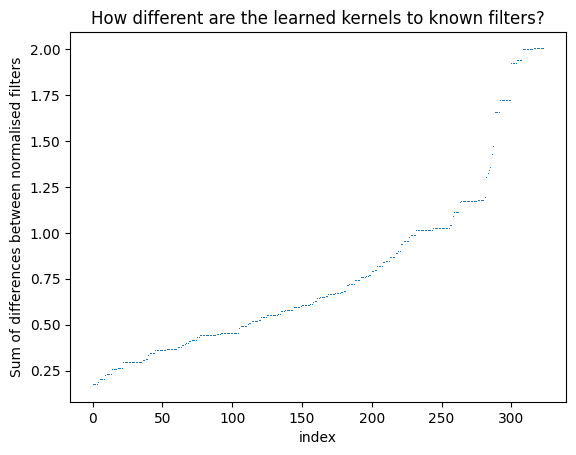

In [10]:
# Output image to see how the differences between kernels and filters range
plt.plot(sorted_differences_dict.values(),',')
plt.title("How different are the learned kernels to known filters?")
plt.xlabel("index")
plt.ylabel("Sum of differences between normalised filters")
# plt.savefig("kernelDifferences.png")

Text(0.5, 1.0, 'sobel filter')

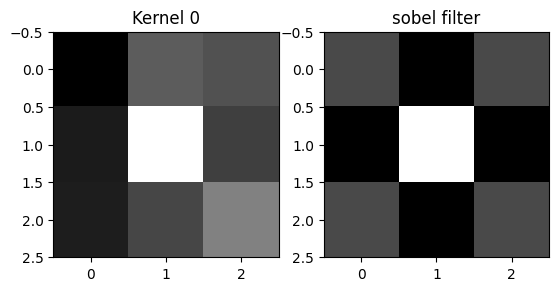

In [11]:
# Output an image of one kernel and a filter

kernel_index = 0
filter_name = "sobel"

plt.subplot(1,2,1)
plt.imshow(normalised_kernels[kernel_index].squeeze(), cmap="binary")
plt.title("Kernel 0")

plt.plot()

plt.subplot(1,2,2)
plt.imshow(normalised_filters[filter_name], cmap='binary')
plt.title(f"{filter_name} filter")